## **Classez des images**

### partie 2/4 : modèle perso

<br>

> #### notebook de mise en oeuvre de création et d’entraînement du modèle personnel, des simulations des différentes valeurs des hyperparamètres et de data augmentation.. <br><br>

<br>


## 0 Imports


### 0.1 Librairies, réglages


In [4]:
# paths, folders/files
import os, sys, random, re
from os import listdir
from glob import glob
from zipfile import ZipFile
import time
import json

# math, dataframes
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from collections import Counter

# Visualisation
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import plotly.express as px
# from wordcloud import WordCloud
# from PIL import Image
from optuna.visualization import plot_optimization_history

# Feature engineering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import manifold, decomposition
from sklearn import cluster, metrics
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer

# NN
import tensorflow as tf
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

import keras_tuner as kt
import optuna
%pip install optuna-integration
from optuna_integration import TFKerasPruningCallback
from functools import partial

# tracking
from mlflow import MlflowClient
import mlflow.keras

# ! REQUIRES CONSOLE COMMAND : mlflow ui
# depuis dossier notebooks
os.environ['MLFLOW_TRACKING_URI'] = './'
# Utilisable seulement en local ?
mlflow.set_tracking_uri("http://localhost:5000")
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")

import pickle

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical


print('\nPython version ' + sys.version)
print('Tensorflow version ' + tf.__version__)
print('Mlflow Autolog compatible with: 2.2.4 <= keras <= 2.6.0')
print('Keras version ' + tf.keras.__version__)
# no autolog... ?

# plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

# Modify if necessary
num_cores = os.cpu_count()
print(f"\nNumber of CPU cores: {num_cores}")
pandarallel.initialize(progress_bar=False, nb_workers=6)


Note: you may need to restart the kernel to use updated packages.

Python version 3.11.5 (main, Sep 11 2023, 13:23:44) [GCC 11.2.0]
Tensorflow version 2.12.0
Mlflow Autolog compatible with: 2.2.4 <= keras <= 2.6.0
Keras version 2.12.0

Number of CPU cores: 8
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### 0.2 Variables globales


In [9]:
nb_classes = 5     # min 2, max 120 (theorique, en pratique les dataframes préparés sont : 3, 4, 5, 10)
                    # possible d'en creer + en utilisant le ntbk 1

size_wh = 128
target_size=(size_wh, size_wh)  # pour grille 5x5, stride (2,2) ?

test_size = 0.15    # same for validation

alea = 42   # pour fixer les ttsplits et tjs travailler sur les mm datasets
# En revanche l'initialisation des poids des modèles restera aléatoire,
# pour pouvoir comparer les resultats sur +ieurs runs.

epochs = 15

nb_runs = 10    # 2-3 le matin, 50 le soir


colab = False
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

    pickle_path_model = f'/content/drive/MyDrive/pickle/best_{nb_classes}/ze_model.pkl'
    pickle_path_accuracy = f'/content/drive/MyDrive/pickle/best_{nb_classes}/best_accuracy_val.pkl'
    pickle_path_params = f'/content/drive/MyDrive/pickle/best_{nb_classes}/best_params.pkl'


for i in [3, 4, 5]: # , 10
    try:
        pickle_path_model = f'./pickle/best_{i}/ze_model.pkl'
        pickle_path_accuracy = f'./pickle/best_{i}/best_accuracy_val.pkl'
        pickle_path_params = f'./pickle/best_{i}/best_params.pkl'

        best_acc = pickle.load(open(pickle_path_accuracy, 'rb'))
        best_parameters = pickle.load(open(pickle_path_params, 'rb'))
        # Parse the JSON string into a dictionary
        # best_parameters = json.loads(best_parameters_string)
    except:
        best_acc = 1 / nb_classes   # proba prediction random, baseline
        best_parameters = {}

    print('\n', f'Best accuracy val on {i} classes :')
    print(best_acc, '\n')
    print('Best_parameters :', '\n')
    pprint(best_parameters)

print(f'Nb de classes prises en compte ds ce ntbk : {nb_classes}')

pickle_path_model = f'./pickle/best_{nb_classes}/ze_model.pkl'
pickle_path_accuracy = f'./pickle/best_{nb_classes}/best_accuracy_val.pkl'
pickle_path_params = f'./pickle/best_{nb_classes}/best_params.pkl'
try:
    best_acc = pickle.load(open(pickle_path_accuracy, 'rb'))
    best_parameters = pickle.load(open(pickle_path_params, 'rb'))
except:
    best_acc = 1 / nb_classes   # proba prediction random, baseline
    best_parameters = {}


features_to_test = ['resized', 'expo', 'contraste', 'denoised_g', 'denoised_bi', 'denoised_nl',
                    'preprocess_complet']

all_features_to_test = ['photo_path'] + features_to_test



 Best accuracy val on 3 classes :
0.7692307829856873 

Best_parameters : 

{'activation': 'tanh',
 'conv_1_units': 12,
 'conv_2_units': 20,
 'dense_units': 192,
 'dim images': '128 x 128 x 3',
 'feature': 'originale, photo_path',
 'model': 'V3',
 'nb epochs': 15,
 'preprocessing': 'norm',
 'size val test sets': 0.15,
 'target': '3_classes',
 'tuner/bracket': 1,
 'tuner/epochs': 15,
 'tuner/initial_epoch': 5,
 'tuner/round': 1,
 'tuner/trial_id': '0019'}

 Best accuracy val on 4 classes :
0.6000000238418579 

Best_parameters : 

{'activation': 'tanh',
 'conv_1_units': 12,
 'conv_2_units': 20,
 'dense_units': 192,
 'dim images': '128 x 128 x 3',
 'feature': 'originale, photo_path',
 'model': 'V3',
 'nb epochs': 15,
 'preprocessing': 'norm',
 'size val test sets': 0.15,
 'target': '4_classes',
 'tuner/bracket': 1,
 'tuner/epochs': 15,
 'tuner/initial_epoch': 5,
 'tuner/round': 1,
 'tuner/trial_id': '0019'}

 Best accuracy val on 5 classes :
0.6666666865348816 

Best_parameters : 

{'acti

### 0.3 Fonctions


In [4]:
# tracking manuel

model_results = []

def affichage_results(multiple=True, best_acc=best_acc):
    """Tracking manuel de nos modèles (data, params, tps, scores) pour comparaison."""

    print(f'{nb_classes} classes prédites')
    print(f'dim images : {size_wh} x {size_wh} x 3')
    print(f'size validation & testing sets : {test_size}')
    print(f'nb epochs : {epochs}', '\n')
    print(f'current best accuracy (validation set) : {best_acc}')

    if multiple:
        print(f'nb runs: {nb_runs}', '\n')

    # Create a DataFrame from the list of model results
    model_comparison_df = pd.concat([pd.DataFrame(model_results)], ignore_index=True)

    # Sort the DataFrame by precision in descending order (higher is better)
    model_comparison_df.sort_values(by='accuracy_val_moy', ascending=False, inplace=True)

    # Display the sorted DataFrame
    display(model_comparison_df)


# tracking mlflow

def create_mlflow_experiment(
    experiment_name: str, artifact_location: str, tags: dict[str, str]
) -> str:
    """
    Create a new mlflow experiment with the given name and artifact location.

    Parameters:
    ----------
    experiment_name: str
        The name of the experiment to create.
    artifact_location: str
        The artifact location of the experiment to create.
    tags: dict[str,Any]
        The tags of the experiment to create.

    Returns:
    -------
    experiment_id: str
        The id of the created experiment.
    """
    try:
        experiment_id = mlflow.create_experiment(
            name=experiment_name, artifact_location=artifact_location, tags=tags
        )
    except:
        print(f"Experiment {experiment_name} already exists.")
        experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

    mlflow.set_experiment(experiment_name=experiment_name)

    return experiment_id


def get_mlflow_experiment(
    experiment_id: str = None, experiment_name: str = None
) -> mlflow.entities.Experiment:
    """
    Retrieve the mlflow experiment with the given id or name.

    Parameters:
    ----------
    experiment_id: str
        The id of the experiment to retrieve.
    experiment_name: str
        The name of the experiment to retrieve.

    Returns:
    -------
    experiment: mlflow.entities.Experiment
        The mlflow experiment with the given id or name.
    """
    if experiment_id is not None:
        experiment = mlflow.get_experiment(experiment_id)
    elif experiment_name is not None:
        experiment = mlflow.get_experiment_by_name(experiment_name)
    else:
        raise ValueError("Either experiment_id or experiment_name must be provided.")

    return experiment


### 0.4 Metriques


In [5]:
# J'utiliserai tjs les noms anglais des métriques ici,
# pour éviter la confusion précision (fr) != precision (en),
# et pour simplement garder les noms des fonctions importées depuis tf.keras.metrics

# Nous sommes dans un cas de classification "classique", 1 classe prédite.
# Une première métrique simple et intuitive est donc l'accuracy :
# nb de prédictions correctes / nb total de prédictions.
# Cette métrique nous suffit déjà pour comparer et optimiser nos modèles.

# Si l'on souhaite étudier + en détail les prédictions des modèles, on utilisera
# la precison et le recall

# Precison (TP / (TP + FP)) :
# Une précision élevée signifie que si une classe est prédite par le modèle,
# alors il y a une forte probabilité (égale à la precision)
# que le chien appartienne en effet à cette classe.

# Recall (TP / (TP + FN)) :
# pour évaluer la capacité des modèles à identifier toutes les instances positives.
# Exemple : Si notre precision est égale à 1, c'est parfais, cela signifie que
# pour une une classe au moins, toutes les valeurs prédites par le modèle sont correctes.
# Cependant, il est possible que cela ne concerne que très peu de cas (mettons, 1 ou 2 prédictions)
# et qu'à côté de cela le modèle a pu faire des milliers de prédictions incorrectes,
# la precision seule ne nous le dit pas.

# Comme l'amélioration de la precision se fait svt au détriment du recall, en pratique
# on combine souvent les 2 avec le f1score (= moyenne harmonique)
# (2 x precision x recall) / (precision + recall)
# qui nous donne directement une idée du compromis precision / recall

# petit souci : le f1score et keras, c'est tout une histoire...
# Dans les versions récentes (depuis la 2.15.0 il me semble), le f1score est directement intégré
# au module metrics. Le problème est que conda n'arrive pas à résoudre un env avec ces versions,
# incompatibles avec les requirements d'autres packages dans l'env.

# Dans les versions + anciennes de keras, le f1score était dans un autre module, "addons",
# mais ce moule est désormais déprécié.
# Solutions : définir un f1score custom
# Pas évident car tensorflow est très pointilleux sur les types d'objets qu'il accepte.
# Exemple : cette fonction est construite en utilisant 2 fonctions tf.keras,
# pourtant elle renvoit une erreur si on tente de l'utiliser parce que le type retourné est
# un float.

def f1score(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    f1 = (2*precision*recall) / (precision + recall)

    return f1

# Autre solution, utiliser le f1score de sk-learn. Compatibilité logging mlflow ?

metrics=[
    'Accuracy',
    # f1score,
    # AUC(),
]


### 0.4 Data


In [6]:
data = pd.read_csv(f'./data/data_{nb_classes}_classes.csv', sep=',')

print(data.shape)
data.head()


(1160, 11)


,photo_path,breed,width,height,resized,expo,contraste,denoised_g,denoised_bi,denoised_nl,preprocess_complet
0,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,333,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...
1,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,375,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...
2,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,400,500,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...
3,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,333,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...
4,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,375,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...


### 0.5 Etude de faisabilité (sort of)


In [7]:
# Ici l'étude de faisabilité préconisée par la méthode Agile n'est pas vraiment utile en tant que telle
# (On sait que le projet est faisable). Il s'agit plutôt de pouvoir observer le travail effectué par le
# bloc d'encodage, sans utiliser d'algorithme de prediction supervisée
# (algo classique ou plutôt, ici, bloc des layers fully connected)

images_features = []

for image_file in data["photo_path"] :
    image = load_img(image_file, target_size=(size_wh, size_wh))
    image = img_to_array(image)
    images_features.append(image)

images_features = np.asarray(images_features)
images_features.shape


(1160, 128, 128, 3)

In [8]:
# Reshape images to flatten them into vectors
flattened_images = images_features.reshape(images_features.shape[0], -1)
print(flattened_images.shape)

# Normalize the data
scaler = StandardScaler()
normalized_images = scaler.fit_transform(flattened_images)


(1160, 49152)


### 0.6 Réduction dim


In [9]:
# PCA

print(normalized_images.shape) # same as flattened_images

pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(normalized_images)

print(feat_pca.shape)

# dimention divisée par 200 (presque), en conservant 99% de la variance !


(1160, 49152)
(1160, 924)


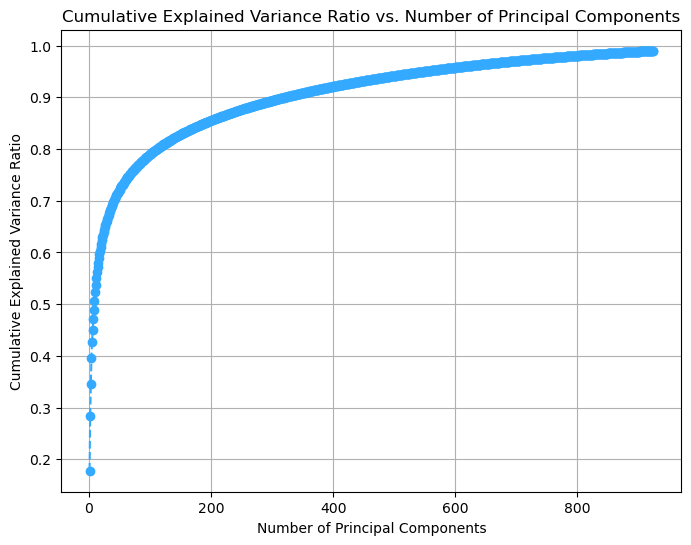

In [10]:
# Plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', color='#3af')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Principal Components')
plt.grid(True)
plt.show()

# Pourquoi on a besoin du tsne pour la visu : en 2D ou même en 3D, les 3 premiers vecteurs propres
# # fournis par la PCA ne captent "que" (environ) un tiers de l'information.
# Ce qu'on verrait serait très déformé par les projections successives de la PCA.
# tester ?


### 0.7 tsne


In [11]:
# t-sne

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)


In [12]:
# encodage target

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(data["breed"])

data["target"] = label_encoder.transform(data["breed"])

display(data.head(1))
data.tail(1)


,photo_path,breed,width,height,resized,expo,contraste,denoised_g,denoised_bi,denoised_nl,preprocess_complet,target
0,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,333,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...,1


,photo_path,breed,width,height,resized,expo,contraste,denoised_g,denoised_bi,denoised_nl,preprocess_complet,target
1159,./data/cleaned_data/0_format/-samoyed/n0211188...,samoyed,400,284,./data/cleaned_data/1_resized_128/-samoyed/n02...,./data/cleaned_data/2_expo_128/-samoyed/n02111...,./data/cleaned_data/3_contraste_128/-samoyed/n...,./data/cleaned_data/4_gauss_denoised_128/-samo...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-s...,./data/cleaned_data/7_preprocess_complet_128/-...,3


/tmp/ipykernel_395752/591859205.py:5: UserWarning: 
The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


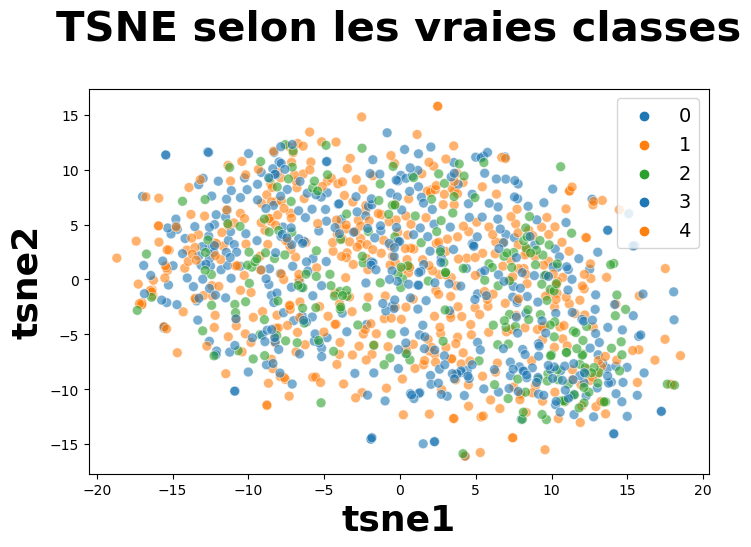

In [13]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["target"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=3), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

# Ca marche moins bien sans extraction de features !
# On retentera en fin de notebook, en utilisant notre modèle.


## 1 Création d'un premier modèle


In [14]:
# Notre objectifs principal ici est
# de pouvoir observer / comprendre la fonction des différentes layers utilisées.

# Pour cela, nous allons commencer par une architecture très simple :
# le but n'est pas d'avoir le modèle le + performant possible.
# (irréaliste ici car on n'aurait ni le tps ni les ressources pour l'entrainer)
# (en revanche, voir le notebook 3, transfer learning, pour une comparaison de modèles + complexes)

# Première idée :
# Notre modèle de base sera donc inspiré d'AlexNet, dont l'architecture est :

# "AlexNet contains eight layers: the first five are convolutional layers,
# some of them followed by max-pooling layers, and the last three are fully connected layers.
# [...] The entire structure can be written as:

# (CNN -> RN -> MP)^2 -> (CNN^3 -> MP) -> (FC -> DO)^2 -> Linear -> softmax

# where
# CNN = convolutional layer (with ReLU activation)
# RN = local response normalization
# MP = maxpooling
# FC = fully connected layer (with ReLU activation)
# Linear = fully connected layer (without activation)
# DO = dropout

# It used the non-saturating ReLU activation function, which showed improved training performance
# over tanh and sigmoid." (wiki)


### 1.1 LeNet inspired architecture


In [15]:
# Problème : 8 groupes de layers... (16 individuelles, en fait) C'est déjà beaucoup !
# On peut faire + simple, au moins pour commencer.

# Voyons de quoi sera capable un modèle inspiré plutôt par LeNet-5
# et par ce notebook : https://www.kaggle.com/code/schmoyote/simple-cnn-architecture-for-image-classification/notebook


def model_v1():
    model = Sequential()
    model.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(size_wh, size_wh, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, kernel_size=(5, 5), activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    # model.add(Dense(120, activation='tanh'))
    model.add(Dense(60, activation='tanh'))
    model.add(Dense(nb_classes, activation='softmax'))

    return model


model = model_v1()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 13456)             0         
                                                                 
 dense (Dense)               (None, 60)                8

 dense_1 (Dense)             (None, 5)                 305       
                                                                 
Total params: 810,597
Trainable params: 810,597
Non-trainable params: 0
_________________________________________________________________


2024-03-31 15:49:10.956652: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### 1.2 feature engineering


In [16]:
feature = "photo_path"


def feature_to_array(feature="photo_path", norm=False, shape_result=False):
    X_feature = []

    for image_file in data[feature] :
        image = load_img(image_file, target_size=target_size)
        image = img_to_array(image)
        if norm:
            image = image / 255
        X_feature.append(image)

    X_feature = np.asarray(X_feature)

    if shape_result:
        pprint(X_feature[:1])
        print('\n', "Shape of X_train:", X_feature.shape)
        # ok

    return X_feature


X_feature = feature_to_array(shape_result=True)


array([[[[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [178., 198., 223.],
         [176., 196., 221.],
         [175., 195., 220.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [178., 198., 223.],
         [177., 197., 222.],
         [176., 196., 221.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [179., 199., 224.],
         [178., 198., 223.],
         [177., 197., 221.]],

        ...,

        [[188., 171., 155.],
         [133., 116., 100.],
         [152., 135., 119.],
         ...,
         [ 62.,  44.,  24.],
         [ 50.,  34.,  18.],
         [ 44.,  44.,  18.]],

        [[ 94.,  86.,  75.],
         [ 91.,  83.,  72.],
         [ 80.,  72.,  61.],
         ...,
         [111.,  94.,  78.],
         [160., 148., 134.],
         [178., 145., 128.]],

        [[208., 194., 181.],
       

### 1.3 label encoding target


In [17]:
y_target = np.asarray(data["target"])
print(y_target.shape)
pprint(y_target)


(1160,)
array([1, 1, 1, ..., 3, 3, 3])


### 1.4 train test split


In [18]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_feature, y_target, test_size=test_size,
                                                            shuffle=True, random_state=alea,
                                                            stratify=y_target) # important

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=test_size,
                                                            shuffle=True, random_state=alea,
                                                            stratify=y_train_val)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape, '\n')

print(y_train.shape)
print(y_val.shape)
print(y_test.shape, '\n')


(838, 128, 128, 3)
(148, 128, 128, 3)
(174, 128, 128, 3) 

(838,)
(148,)
(174,) 



### 1.5 one hot encoding (targets)


In [19]:
# One-hot encode target values after the split to avoid data leakage

y_train_ohe = tf.keras.utils.to_categorical(y_train)
y_val_ohe = tf.keras.utils.to_categorical(y_val)
y_test_ohe = tf.keras.utils.to_categorical(y_test)


### 1.6 Training


In [20]:
# Train the model
model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
          validation_data=(X_val, y_val_ohe), verbose=0) # verbose=0 avoids crashing cell later


### 1.7 Evaluation


In [21]:
# On overfit dès le début ??

# Evaluate the model
val_loss_ref, val_acc_ref = model.evaluate(X_val, y_val_ohe)
print(f'Val accuracy: {val_acc_ref}', '\n')

# En prédisant au hasard on aurait une chance sur 3, autrement dit
# ce modèle fait des prédictions quasi-aléatoires.
# Pas terrible, mais c'est un début !

# avant, tester sur photos d'origine (pour évaluer l'utilité du prétraitement effectué)



1/5 [=====>........................] - ETA: 0s - loss: 1.5964 - Accuracy: 0.2188

5/5 [==============================] - 0s 40ms/step - loss: 1.6085 - Accuracy: 0.2162
Val accuracy: 0.21621622145175934 



### save


In [22]:
parameters = {
    "model": "V1",
    "preprocessing": 'no_norm',
    "feature": feature,
    'target': f'{nb_classes}_classes',
    'dim images': f'{size_wh} x {size_wh} x 3',
    'size val test sets': test_size,
    'nb epochs': epochs
}


def save_model_if_better_than_the_best(model=model, acc=val_acc_ref, best_params=parameters):

    global best_acc

    if acc > best_acc:
        print(f'Improving! Accuracy up to {acc}')
        best_acc = acc
        # erreur logging, saving instead
        # using mlflow
        # mlflow.keras.save_model(model, "./best_model") # works only once
        # using pickle
        with open(pickle_path_model, 'wb') as f:
            pickle.dump(model, f)
        # also save best accuracy
        with open(pickle_path_accuracy, 'wb') as f:
            pickle.dump(best_acc, f)
        # and corresponding best params
        with open(pickle_path_params, 'wb') as f:
            pickle.dump(best_params, f)


save_model_if_better_than_the_best()


Improving! Accuracy up to 0.21621622145175934


In [23]:
# petit tracking manuel
results = {'model': 'V1',
            'df': 'data_3_classes',
            'feature': feature,
            'accuracy_val_moy': val_acc_ref,
            'time_fit': 'to do',
            'time_predict':'to do'
            }

# Append a new row for this model
model_results.append(results)


### 1.8 test utilité prétraitements


In [24]:
experiment_id = create_mlflow_experiment(
    experiment_name="analyse_pretraitements",
    artifact_location="./mlruns/artifacts",
    tags={"model": "V1", "preprocessing": 'no_norm', "features": "7_processed_features", 'target': '3_classes'},
)


Experiment analyse_pretraitements already exists.


In [25]:
# resized


def test_feature(df=data, feature='photo_path', epochs=epochs):
    parameters = {
        "model": "V1",
        "preprocessing": 'no_norm',
        "feature": feature,
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters)

    # feature, target
    X_feature = feature_to_array(feature)
    y_target = np.asarray(df["target"])

    #tt split
    X_train_val, X_test, y_train_val, y_test = train_test_split(X_feature, y_target, test_size=0.1,
                                                                shuffle=True, random_state=alea,
                                                                stratify=y_target) # important

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1,
                                                                shuffle=True, random_state=alea,
                                                                stratify=y_train_val)

    # ohe cible
    y_train_ohe = tf.keras.utils.to_categorical(y_train)
    y_val_ohe = tf.keras.utils.to_categorical(y_val)
    y_test_ohe = tf.keras.utils.to_categorical(y_test)

    # model
    model = model_v1()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

    model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
            validation_data=(X_val, y_val_ohe), verbose=0)

    _, val_acc = model.evaluate(X_val, y_val_ohe, verbose=0)

    save_model_if_better_than_the_best(model=model, acc=val_acc, best_params=parameters)

    metrix = {
        "accuracy_val": val_acc
    }
    # multiple metrics
    mlflow.log_metrics(metrix)

    print(f'Val accuracy (feature={feature}): {val_acc}')

    results = {'model': 'V1',
            'df': 'data_3_classes',
            'feature': feature,
            'accuracy_val_moy': val_acc,
            'time_fit': 'to do',
            'time_predict':'to do'
            }

    # Append a new row for this model
    model_results.append(results)

    return val_acc


# _ = test_feature(df=data, feature='resized')


# 0.6 de precision sans pretraitement (parfois 0.3 ??), 0.3 avec.
# Notre prétraitement semble (très) contre-productif. Ajuster dim, filtres ? (trop flou ?)
# Comme prétraitement, les méthodes .preprocessing() de keras consistent svt seulement en
# redimensionnemt + normalisation.
# faire pareil ?


In [26]:
# nested

experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))

with mlflow.start_run(run_name="7_processed_features_once", experiment_id=experiment_id) as parent:
    all_metrics = {}

    for feature in features_to_test:
        print('\n', feature)
        with mlflow.start_run(run_name=f'{feature}', nested=True) as child:
            print(f'RUN ID child_{feature}: {child.info.run_id}')
            accuracy_val = test_feature(df=data, feature=feature)
            all_metrics[f'accuracy_{feature}'] = accuracy_val

    print('\n')
    pprint(all_metrics)
    mlflow.log_metrics(all_metrics)

# results
# 'resized' 0.32 ???
# 'expo' 0.63
# 'contraste' 0.32

# rappel
print(f'\nRappel : Val accuracy (photo_path original) = {val_acc_ref}')


Name: analyse_pretraitements

 resized
RUN ID child_resized: 0eae956f02ca4b078b588140e3d65e38


Improving! Accuracy up to 0.21904762089252472
Val accuracy (feature=resized): 0.21904762089252472

 expo
RUN ID child_expo: b25bb79b152041dba463fc1312fd1f02
Val accuracy (feature=expo): 0.20000000298023224

 contraste
RUN ID child_contraste: 1802f8713eaf48cfbcd45f6d766cdbec
Improving! Accuracy up to 0.5047619342803955
Val accuracy (feature=contraste): 0.5047619342803955

 denoised_g
RUN ID child_denoised_g: 30364659462747118b5597204a835cd9
Val accuracy (feature=denoised_g): 0.4761904776096344

 denoised_bi
RUN ID child_denoised_bi: 60c05469635f455e87cd2fee37c031f3
Val accuracy (feature=denoised_bi): 0.21904762089252472

 denoised_nl
RUN ID child_denoised_nl: d1980495b5674d7c967b76f95ff1d284
Val accuracy (feature=denoised_nl): 0.32380953431129456

 preprocess_complet
RUN ID child_preprocess_complet: c3a3324dcb854ba9b1c100a1aaaed418
Val accuracy (feature=preprocess_complet): 0.190476194024086


{'accuracy_contraste': 0.5047619342803955,
 'accuracy_denoised_bi': 0.21904762089252472,
 'acc

### Comparaison


In [27]:
affichage_results(multiple=False, best_acc=best_acc)

# On y voit déjà (un peu) + clair :
# Chaque étape de notre prétraitement semble + ou - détériorer la qualité des prédictions.

# Encore que... ?
# ??? resized et photo_path devraient donner des résultats bien + proches, non ??
# sets identiques sauf dim, et redim lors de création de X_feature
# ... devraient être exactement identiques, et donc avoir des resultats proches

# En fait d'un run à l'autre, les prédictions varient énormément...
# difficile du coup d'évaluer l'impact de nos prétraitements.
# moyenne sur +ieurs runs ?

model_results = []

# (Très) svt le modèle ne parvient pas à "train ses layers", et l'accuracy des prédictions
# sur le jeu de validation reste au niveau de prédictions random.


5 classes prédites
dim images : 128 x 128 x 3
size validation & testing sets : 0.15
nb epochs : 15 

current best accuracy (validation set) : 0.5047619342803955


,model,df,feature,accuracy_val_moy,time_fit,time_predict
3,V1,data_3_classes,contraste,0.504762,to do,to do
4,V1,data_3_classes,denoised_g,0.476190,to do,to do
6,V1,data_3_classes,denoised_nl,0.323810,to do,to do
1,V1,data_3_classes,resized,0.219048,to do,to do
5,V1,data_3_classes,denoised_bi,0.219048,to do,to do
0,V1,data_3_classes,photo_path,0.216216,to do,to do
2,V1,data_3_classes,expo,0.200000,to do,to do
7,V1,data_3_classes,preprocess_complet,0.190476,to do,to do


### Mean multiple runs


In [28]:
experiment_id = create_mlflow_experiment(
    experiment_name='analyse_pretraitmt_multiple_runs',
    artifact_location="./mlruns/artifacts",
    tags={"model": "V1", "preprocessing": 'no_norm', "features": "all_8_features", 'target': '3_classes'},
)


Experiment analyse_pretraitmt_multiple_runs already exists.


In [29]:
#


def test_feature_n_times(feature='photo_path', epochs=epochs, n=nb_runs):
    """

    """
    parameters = {
        "model": "V1",
        "preprocessing": 'no_norm',
        "feature": feature,
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters) # child

    results_val_acc, results_time_fit,  results_time_predict = [], [], []

    for i in range(n):

        with mlflow.start_run(run_name=f'run_{i}', nested=True) as grand_kid:
            print(f'\nRun {i}\n')
            print("RUN ID ", grand_kid.info.run_id )
            mlflow.log_params(parameters) # grand_kid

            # feature, target
            X_feature = feature_to_array(feature)
            y_target = np.asarray(data["target"])

            X_train_val, X_test, y_train_val, y_test = train_test_split(X_feature, y_target, test_size=0.1,
                                                                        shuffle=True, random_state=alea,
                                                                        stratify=y_target) # important

            X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1,
                                                                        shuffle=True, random_state=alea,
                                                                        stratify=y_train_val)

            y_train_ohe = tf.keras.utils.to_categorical(y_train)
            y_val_ohe = tf.keras.utils.to_categorical(y_val)
            y_test_ohe = tf.keras.utils.to_categorical(y_test)

            # model
            model = model_v1()

            # Compile the model
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

            # fit model and time it
            time_fit_start = time.time() # returns the time in seconds since the epoch.
            model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
                    validation_data=(X_val, y_val_ohe), verbose=0)
            time_fit_end = time.time()
            time_fit = time_fit_end - time_fit_start

            # time predictions
            time_predict_start = time.time()
            _, val_acc = model.evaluate(X_val, y_val_ohe) # , verbose=0 ?
            time_predict_end = time.time()
            time_predict = time_predict_end - time_predict_start

            # print(f'Val accuracy (feature={feature}): {val_acc}')

            save_model_if_better_than_the_best(model=model, acc=val_acc, best_params=parameters)

            metriq = {
                "accuracy_val": val_acc,
                "time_fit": time_fit,
                "time_predict": time_predict
            }
            mlflow.log_metrics(metriq)

            results_val_acc.append(val_acc)
            results_time_fit.append(time_fit)
            results_time_predict.append(time_predict)

            # Log the model doesn't work ??
            # mlflow.keras.log_model(model=model, artifact_path="good_model",registered_model_name='best_model')

    # moyennes
    mean_val_acc = np.mean(results_val_acc)
    mean_time_fit = np.mean(results_time_fit)
    mean_time_predict = np.mean(results_time_predict)

    # écarts-types (utile ici pour le score, afin d'avoir une idée de la "régularité" des résultats)
    # les tps d'entrainement / prédiction st bcp + stables
    std_val_acc = np.std(results_val_acc)

    metrix = {
        "accuracy_val_moy": mean_val_acc,
        "accuracy_val_std": std_val_acc,
        "time_fit_moy": mean_time_fit,
        "time_predict_moy": mean_time_predict
    }
    for run in range(nb_runs):
        metrix[f'accuracy_val_run_{run}'] = results_val_acc[run]

    # multiple metrics
    mlflow.log_metrics(metrix)

    results = {'model': 'V1',
        'df': 'data_3_classes',
        'feature': feature,
        'accuracy_val_moy': mean_val_acc,
        'accuracy_val_std': std_val_acc,
        'time_fit_moy (s)': mean_time_fit,
        'time_predict_moy (s)': mean_time_predict,
        }

    # Append a new row for this model
    model_results.append(results)

    print('\n', f'Accuracy val {feature}, moyenne : {mean_val_acc}')
    print(f'Accuracy val {feature}, écart-type : {std_val_acc}')

    # + tard
    # log model
    # mlflow.sklearn.log_model(sk_model=knn_ref, artifact_path="special_knn")

     # Save a plot
    # plt.savefig("./artifacts/jaccard_plot_3_4_tags.png")
    # Log the saved figure using MLflow
    # mlflow.log_artifact("./artifacts/jaccard_plot_3_4_tags.png")

    return metrix


# _ = test_feature_n_times()

#


In [30]:
# nested

experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))


with mlflow.start_run(run_name="test_all_8_features", experiment_id=experiment_id) as parent:
    parameters = {
        "model": "V1",
        "preprocessing": 'no_norm',
        "feature": feature,
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters) # parent

    all_metrics = {}

    for feature in all_features_to_test:
        print('\n', feature)
        with mlflow.start_run(run_name=f'{feature}', nested=True) as child:
            print(f'RUN ID child_{feature}: {child.info.run_id}', '\n')
            metrix = test_feature_n_times(feature=feature)
            all_metrics[f'accuracy_val_moy_{feature}'] = metrix['accuracy_val_moy']

    print('\n')
    pprint(all_metrics)
    mlflow.log_metrics(all_metrics) # perfect


# results
# 'resized' 0.32 ???
# 'expo' 0.63
# 'contraste' 0.32


Name: analyse_pretraitmt_multiple_runs

 photo_path
RUN ID child_photo_path: 0cbd50f29cba48abbc41977526d5d402 


Run 0

RUN ID  25fd24cde3b8493f901a1255f46cc146


4/4 [==============================] - 0s 65ms/step - loss: 1.6094 - accuracy: 0.2190

Run 1

RUN ID  948ed5bb24524bc1bdc58f694fec5e08
4/4 [==============================] - 0s 29ms/step - loss: 1.4362 - accuracy: 0.4286

Run 2

RUN ID  5e41a3a87de7469b94c82b82a1bbfcb3
4/4 [==============================] - 0s 26ms/step - loss: 1.6091 - accuracy: 0.2000

Run 3

RUN ID  0894ec5b7fa2413b9647e6c55e7fba89
4/4 [==============================] - 0s 23ms/step - loss: 1.6087 - accuracy: 0.2190

Run 4

RUN ID  d1547bd8b573496d984c32d2d824e790
4/4 [==============================] - 0s 36ms/step - loss: 1.6235 - accuracy: 0.2000

Run 5

RUN ID  3c961deefc184cbd9b637d694a84face
4/4 [==============================] - 0s 19ms/step - loss: 1.6083 - accuracy: 0.2190

Run 6

RUN ID  d2220165746c4c2f9263755d3b99431c
4/4 [==============================] - 0s 23ms/step - loss: 1.6090 - accuracy: 0.2000

Run 7

RUN ID  9c2e8c5909174f3589335fbb996fd072
4/4 [==============================] - 0s 17ms/step - l

In [31]:
affichage_results(best_acc=best_acc)

# Enfin des résultats interprétables !
# Cpdt le nb de runs est encore très faible, et les résultats st très proches.

# model_results = []

# log / picle model. size ?

# les pretraitements expo / contraste semblent bénéfiques,
# en revanche le filtre gaussien mm léger ici semble avoir un impact légèrement négatif
# sur les prédictions du modèle. Le modèle n'aime pas le flou !

# (encore une fois, ces "conclusions" sont à prendre "avec des pincettes", en attendant
# des runs supplémentaires.)


5 classes prédites
dim images : 128 x 128 x 3
size validation & testing sets : 0.15
nb epochs : 15 

current best accuracy (validation set) : 0.523809552192688
nb runs: 10 



,model,df,feature,accuracy_val_moy,accuracy_val_std,time_fit_moy (s),time_predict_moy (s)
3,V1,data_3_classes,contraste,0.297143,0.107395,67.126505,0.245699
2,V1,data_3_classes,expo,0.292381,0.127637,62.981827,0.299475
6,V1,data_3_classes,denoised_nl,0.282857,0.117730,64.218917,0.303063
7,V1,data_3_classes,preprocess_complet,0.277143,0.099837,76.582868,0.374858
0,V1,data_3_classes,photo_path,0.232381,0.066010,61.595837,0.221278
5,V1,data_3_classes,denoised_bi,0.222857,0.011429,55.403374,0.250390
1,V1,data_3_classes,resized,0.213333,0.008729,63.126930,0.244159
4,V1,data_3_classes,denoised_g,0.213333,0.008729,54.803034,0.234764


In [32]:
# A propos de la fonction d'activation tanh

# Choisi tanh pour commencer, une fonction d'activation "historique",
# +tôt que relu (+ utilisée dans les archis des modèles + récents)
# parce que la tangeante hyperbolique agit comme un scaler :
# Elle centre les valeurs autour de 0, sur l'intervalle [-1, 1]

# du coup pas besoin de normaliser nos pixels au préalable.
# Quand on testera relu, il faudra comparer avec ou sans normalisation.

# Autre caractéristique intéressante de la fonction tanh :

# La symétrie par rapport à l'origine + normalisation peuvent aider les algorithmes à optimiser le modèle,
# en empêchant les gradients de devenir trop proches de 0 (problème fréquent du 'vanishing gradient')
# ou au contraire trop importants ('exploding gradient') pdt la backpropagation.
# Il est cpdt tjs possible de rencontrer un vanishing gradient.


## 2 Ameliorations


In [33]:
# 3 pistes -> améliorations possibles :

# retour au preprocessing,
# data augmentation,
# améliorer le model lui-même.

# Nous allons commencer par le modèle, car parvenir à obtenir un modèle + consistent
# (= faire baisser la sdt) rendrait l'analyse des pretraitements et de la data augmentation
# bcp + fiable.


### keras-tuner, archi 1


In [34]:
experiment_id = create_mlflow_experiment(
    experiment_name='keras_tuner_1_archi',
    artifact_location="./mlruns/artifacts",
    tags={"model": "V2", "preprocessing": 'no_norm', "feature": "photo_path", 'target': '3_classes'},
)

experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))


Experiment keras_tuner_1_archi already exists.
Name: keras_tuner_1_archi


In [35]:
# tester Optuna ? (compatible sk-learn + tracking ui)
# kt très facile à intégrer ici, puisque nous utilisons uniquement keras
# syntaxe légèrement + simple (mais les 2 st assez proches)
# (sauf / f1score ?)

# Commençons par qq hyperparams de l'architecture générale de notre modèle :
# (On espère "alléger" le modèle, pour le rendre plus facile a entrainer.)
# nb de filtres (pour les 2 couches de convolution)
# nb neurons (first fully-connected layer)


def build_model(hp):

    model = Sequential()
    model.add(Conv2D(hp.Int("conv_1_units", min_value=4, max_value=32, step=4),
                     kernel_size=(5, 5), activation='tanh', input_shape=(size_wh, size_wh, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(hp.Int("conv_2_units", min_value=4, max_value=32, step=4),
                     kernel_size=(5, 5), activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(hp.Int("dense_units", min_value=32, max_value=192, step=32), activation='tanh'))
    model.add(Dense(nb_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


def test_archi_n_times(feature='photo_path', epochs=epochs, n=nb_runs, model_name='V2_kt',
                       norm=False, dir='keras_tuner/archi_1'):
    """
    """

    tuner = kt.Hyperband(build_model,
                         objective='val_accuracy',
                         max_epochs=epochs,
                         factor=3,
                         directory=dir,
                         project_name=model_name)

    results_val_acc, results_time_fit,  results_time_predict = [], [], []

    for i in range(n):
        with mlflow.start_run(run_name=f'run_{i}', nested=True) as kid:
            print(f'\nRun {i}\n')
            print("RUN ID ", kid.info.run_id)

            # feature, target
            X_feature = feature_to_array(feature, norm=norm)
            y_target = np.asarray(data["target"])

            X_train_val, X_test, y_train_val, y_test = train_test_split(X_feature, y_target, test_size=0.1,
                                                                        shuffle=True, random_state=alea,
                                                                        stratify=y_target) # important

            X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1,
                                                                        shuffle=True, random_state=alea,
                                                                        stratify=y_train_val)

            y_train_ohe = tf.keras.utils.to_categorical(y_train)
            y_val_ohe = tf.keras.utils.to_categorical(y_val)
            y_test_ohe = tf.keras.utils.to_categorical(y_test)

            tuner.search(X_train, y_train_ohe, validation_data=(X_val, y_val_ohe))

            # Get the optimal hyperparameters
            best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

            # Build the model with the optimal hyperparameters
            model = tuner.hypermodel.build(best_hps)

            # Fit model and time it
            time_fit_start = time.time()
            model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
                    validation_data=(X_val, y_val_ohe), verbose=0)
            time_fit_end = time.time()
            time_fit = time_fit_end - time_fit_start

            # Time predictions
            time_predict_start = time.time()
            _, val_acc = model.evaluate(X_val, y_val_ohe) # , verbose=0 ?
            time_predict_end = time.time()
            time_predict = time_predict_end - time_predict_start

            # print(f'Val accuracy (feature={feature}): {val_acc}', '\n')

            parameters.update(best_hps.values)
            mlflow.log_params(parameters)

            save_model_if_better_than_the_best(model=model, acc=val_acc, best_params=parameters)

            metriq = {
                "accuracy_val": val_acc,
                "time_fit": time_fit,
                "time_predict": time_predict
            }
            mlflow.log_metrics(metriq)


            results_val_acc.append(val_acc)
            results_time_fit.append(time_fit)
            results_time_predict.append(time_predict)

    # Calculate averages
    mean_val_acc = np.mean(results_val_acc)
    mean_time_fit = np.mean(results_time_fit)
    mean_time_predict = np.mean(results_time_predict)

    # Calculate standard deviations
    std_val_acc = np.std(results_val_acc)

    metrix = {
        "accuracy_val_moy": mean_val_acc,
        "accuracy_val_std": std_val_acc,
        "time_fit_moy": mean_time_fit,
        "time_predict_moy": mean_time_predict
    }
    for run in range(nb_runs):
        metrix[f'accuracy_val_run_{run}'] = results_val_acc[run]

    # multiple metrics
    mlflow.log_metrics(metrix)

    results = {'model': model_name,
               'df': 'data_3_classes',
               'feature': feature,
               'accuracy_val_moy': mean_val_acc,
               'accuracy_val_std': std_val_acc,
               'time_fit_moy (s)': mean_time_fit,
               'time_predict_moy (s)': mean_time_predict,
              }

    # Append a new row for this model
    model_results.append(results)

    print(f'Accuracy val {feature}, moyenne : {mean_val_acc}')
    print(f'Accuracy val {feature}, écart-type : {std_val_acc}', '\n')

    print("Best Hyperparameters:")
    print(best_hps.values)

    return metrix


#  _ = test_archi_n_times()

# wow
# Reloading Tuner from keras_tuner_dir/test_kt/tuner0.json
# kt ne perd pas de tps et récupère directement les hyperparamètres
# Au final il semble légèrement + rapide d'utiliser kt !


In [36]:
with mlflow.start_run(run_name="test_archi_1", experiment_id=experiment_id) as parent:
    parameters = {
        "model": "V2",
        "preprocessing": 'no_norm',
        "feature": 'originale, photo_path',
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters)

    all_metrics = {}

    metrix = test_archi_n_times()

    all_metrics[f'accuracy_val_moy_{feature}'] = metrix['accuracy_val_moy']

    print('\n')
    pprint(all_metrics)
    mlflow.log_metrics(all_metrics)


Reloading Tuner from keras_tuner/archi_1/V2_kt/tuner0.json

Run 0

RUN ID  0ad6bab2659546e691948f5ff2041ce0


4/4 [==============================] - 0s 46ms/step - loss: 1.6151 - accuracy: 0.2000

Run 1

RUN ID  acab6c3cae064d79a4bf391d511f8b01
4/4 [==============================] - 0s 60ms/step - loss: 1.6201 - accuracy: 0.1905

Run 2

RUN ID  50ea2388d50b4868b520f9e976d95bbb
4/4 [==============================] - 0s 40ms/step - loss: 1.6094 - accuracy: 0.2095

Run 3

RUN ID  c4a000462d0f4fa39161e7f7d0c6f3fd
4/4 [==============================] - 0s 53ms/step - loss: 1.6175 - accuracy: 0.1905

Run 4

RUN ID  1e359ded884a49d4bf41bf92e376077d
4/4 [==============================] - 0s 41ms/step - loss: 1.6456 - accuracy: 0.2190

Run 5

RUN ID  f6240476176a4024a9f656e33824a86e
4/4 [==============================] - 0s 51ms/step - loss: 1.6255 - accuracy: 0.2000

Run 6

RUN ID  45dc66d862c1470cb1e5a7c41f896c22
4/4 [==============================] - 0s 40ms/step - loss: 1.6198 - accuracy: 0.2000

Run 7

RUN ID  ef166e2de1a24505b4552f5f9c8059c6
4/4 [==============================] - 0s 55ms/step - l

In [37]:
affichage_results(best_acc=best_acc)

# Enfin un écart significatif !
# std tjs élevé (tjs l'aléatoire / initialisation)


5 classes prédites
dim images : 128 x 128 x 3
size validation & testing sets : 0.15
nb epochs : 15 

current best accuracy (validation set) : 0.523809552192688
nb runs: 10 



,model,df,feature,accuracy_val_moy,accuracy_val_std,time_fit_moy (s),time_predict_moy (s)
3,V1,data_3_classes,contraste,0.297143,0.107395,67.126505,0.245699
2,V1,data_3_classes,expo,0.292381,0.127637,62.981827,0.299475
6,V1,data_3_classes,denoised_nl,0.282857,0.117730,64.218917,0.303063
7,V1,data_3_classes,preprocess_complet,0.277143,0.099837,76.582868,0.374858
8,V2_kt,data_3_classes,photo_path,0.238095,0.071270,94.120062,0.315100
0,V1,data_3_classes,photo_path,0.232381,0.066010,61.595837,0.221278
5,V1,data_3_classes,denoised_bi,0.222857,0.011429,55.403374,0.250390
1,V1,data_3_classes,resized,0.213333,0.008729,63.126930,0.244159
4,V1,data_3_classes,denoised_g,0.213333,0.008729,54.803034,0.234764


### keras-tuner, fonction d'activation


In [38]:
experiment_id = create_mlflow_experiment(
    experiment_name='keras_tuner_2_activation',
    artifact_location="./mlruns/artifacts",
    tags={"model": "V3", "preprocessing": 'no_norm', "feature": "photo_path", 'target': '3_classes'},
)

experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))


Experiment keras_tuner_2_activation already exists.
Name: keras_tuner_2_activation


In [39]:
# Continuons en testant la fonction d'activation relu

# tester Optuna ? (compatible sk-learn)
# kt très facile à intégrer ici, puisque nous utilisons uniquement keras
# (sauf / f1score ?)

# Commençons par qq hyperparams de l'architecture générale de notre modèle :
# nb de filtres (pour les 2 couches de convolution)
# nb neurons (first fully-connected layer)

def build_model(hp):

    model = Sequential()
    model.add(Conv2D(hp.Int("conv_1_units", min_value=4, max_value=32, step=4),kernel_size=(5, 5),
                     activation=hp.Choice("activation", ["relu", "tanh"]),
                     input_shape=(size_wh, size_wh, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(hp.Int("conv_2_units", min_value=4, max_value=32, step=4),
                     kernel_size=(5, 5), activation=hp.Choice("activation", ["relu", "tanh"])))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(hp.Int("dense_units", min_value=32, max_value=192, step=32),
                    activation=hp.Choice("activation", ["relu", "tanh"])))
    model.add(Dense(nb_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


with mlflow.start_run(run_name="test_activation", experiment_id=experiment_id) as parent:
    parameters = {
        "model": "V3",
        "preprocessing": 'no_norm',
        "feature": 'originale, photo_path',
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters)

    all_metrics = {}

    metrix = test_archi_n_times(model_name='V3_kt_activ', dir='keras_tuner/activ')

    all_metrics[f'accuracy_val_moy_{feature}'] = metrix['accuracy_val_moy']

    print('\n')
    pprint(all_metrics)
    mlflow.log_metrics(all_metrics)


# {'conv_1_units': 28, 'activation': 'tanh', 'conv_2_units': 4, 'dense_units': 96


Reloading Tuner from keras_tuner/activ/V3_kt_activ/tuner0.json

Run 0

RUN ID  ccdff764802c4b90b23b5f36e5577cb5


4/4 [==============================] - 0s 29ms/step - loss: 1.3660 - accuracy: 0.5810
Improving! Accuracy up to 0.5809524059295654

Run 1

RUN ID  6894341852fa4ef2a5b9e8f10cee4571
4/4 [==============================] - 0s 29ms/step - loss: 1.2929 - accuracy: 0.6667
Improving! Accuracy up to 0.6666666865348816

Run 2

RUN ID  eddeac86407842dfb4b7c71c8dd088ed
4/4 [==============================] - 0s 34ms/step - loss: 1.6280 - accuracy: 0.2190

Run 3

RUN ID  6d17544ae0074e6f92429d3dce046862
4/4 [==============================] - 0s 38ms/step - loss: 1.6164 - accuracy: 0.1905

Run 4

RUN ID  8f66ba550cfb4e4baf056d1b570ac4fa
4/4 [==============================] - 0s 54ms/step - loss: 1.6060 - accuracy: 0.2381

Run 5

RUN ID  6daaaa0803f14a25a56564dda85351c2
4/4 [==============================] - 0s 53ms/step - loss: 1.5063 - accuracy: 0.2952

Run 6

RUN ID  c00f983c98564af88c0f09a753cfc984
4/4 [==============================] - 0s 85ms/step - loss: 1.6212 - accuracy: 0.2000

Run 7

RUN ID

In [40]:
affichage_results(best_acc=best_acc)

# tjs très aléatoire.
# std ?

# relu sans normalisation ici


5 classes prédites
dim images : 128 x 128 x 3
size validation & testing sets : 0.15
nb epochs : 15 

current best accuracy (validation set) : 0.6666666865348816
nb runs: 10 



,model,df,feature,accuracy_val_moy,accuracy_val_std,time_fit_moy (s),time_predict_moy (s)
9,V3_kt_activ,data_3_classes,photo_path,0.323810,0.165287,84.198843,0.304740
3,V1,data_3_classes,contraste,0.297143,0.107395,67.126505,0.245699
2,V1,data_3_classes,expo,0.292381,0.127637,62.981827,0.299475
6,V1,data_3_classes,denoised_nl,0.282857,0.117730,64.218917,0.303063
7,V1,data_3_classes,preprocess_complet,0.277143,0.099837,76.582868,0.374858
8,V2_kt,data_3_classes,photo_path,0.238095,0.071270,94.120062,0.315100
0,V1,data_3_classes,photo_path,0.232381,0.066010,61.595837,0.221278
5,V1,data_3_classes,denoised_bi,0.222857,0.011429,55.403374,0.250390
1,V1,data_3_classes,resized,0.213333,0.008729,63.126930,0.244159
4,V1,data_3_classes,denoised_g,0.213333,0.008729,54.803034,0.234764


### normalisation + fonction d'activation


In [41]:
experiment_id = create_mlflow_experiment(
    experiment_name='keras_tuner_2_activation_norm',
    artifact_location="./mlruns/artifacts",
    tags={"model": "V3", "preprocessing": 'normalisation', "feature": "photo_path", 'target': '3_classes'},
)

experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))


Experiment keras_tuner_2_activation_norm already exists.
Name: keras_tuner_2_activation_norm


In [42]:
with mlflow.start_run(run_name="activation_norm", experiment_id=experiment_id) as parent:
    parameters = {
        "model": "V3",
        "preprocessing": 'norm',
        "feature": 'originale, photo_path',
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters)

    all_metrics = {}

    metrix = test_archi_n_times(model_name='V3_kt_activ_norm', norm=True, dir='keras_tuner/norm_activ')

    all_metrics[f'accuracy_val_moy_{feature}'] = metrix['accuracy_val_moy']

    print('\n')
    pprint(all_metrics)
    mlflow.log_metrics(all_metrics)


Reloading Tuner from keras_tuner/norm_activ/V3_kt_activ_norm/tuner0.json

Run 0

RUN ID  0819b3ea47de4bd4a2aa9bc700cd66b9


4/4 [==============================] - 0s 56ms/step - loss: 1.4149 - accuracy: 0.5905

Run 1

RUN ID  61be6e3092294cf5af52767fb85c6920
4/4 [==============================] - 0s 60ms/step - loss: 1.6269 - accuracy: 0.2190

Run 2

RUN ID  fb9875fc0c334490b16ae1fc18fa869e
4/4 [==============================] - 0s 57ms/step - loss: 1.6171 - accuracy: 0.5238

Run 3

RUN ID  1b838adb0ffc48aabff066f646e225b6
4/4 [==============================] - 0s 39ms/step - loss: 1.2185 - accuracy: 0.5524

Run 4

RUN ID  44500d817fd6415d9354170b9dbd604d
4/4 [==============================] - 0s 57ms/step - loss: 1.3963 - accuracy: 0.5429

Run 5

RUN ID  65511035d52247ecb2ff5a6555e0966f
4/4 [==============================] - 0s 75ms/step - loss: 1.8264 - accuracy: 0.4952

Run 6

RUN ID  cf6fc0925c5344f2b6370a229a101728
4/4 [==============================] - 0s 57ms/step - loss: 1.3853 - accuracy: 0.5714

Run 7

RUN ID  c4a65a41ccc14248af13f003f08e62c5
4/4 [==============================] - 0s 52ms/step - l

In [43]:
affichage_results(best_acc=best_acc)


5 classes prédites
dim images : 128 x 128 x 3
size validation & testing sets : 0.15
nb epochs : 15 

current best accuracy (validation set) : 0.6666666865348816
nb runs: 10 



,model,df,feature,accuracy_val_moy,accuracy_val_std,time_fit_moy (s),time_predict_moy (s)
10,V3_kt_activ_norm,data_3_classes,photo_path,0.526667,0.107501,99.885986,0.364137
9,V3_kt_activ,data_3_classes,photo_path,0.323810,0.165287,84.198843,0.304740
3,V1,data_3_classes,contraste,0.297143,0.107395,67.126505,0.245699
2,V1,data_3_classes,expo,0.292381,0.127637,62.981827,0.299475
6,V1,data_3_classes,denoised_nl,0.282857,0.117730,64.218917,0.303063
7,V1,data_3_classes,preprocess_complet,0.277143,0.099837,76.582868,0.374858
8,V2_kt,data_3_classes,photo_path,0.238095,0.071270,94.120062,0.315100
0,V1,data_3_classes,photo_path,0.232381,0.066010,61.595837,0.221278
5,V1,data_3_classes,denoised_bi,0.222857,0.011429,55.403374,0.250390
1,V1,data_3_classes,resized,0.213333,0.008729,63.126930,0.244159


### optuna


In [44]:
experiment_id = create_mlflow_experiment(
    experiment_name='optuna_1_activ',
    artifact_location="./mlruns/artifacts",
    tags={"model": "V4", "preprocessing": 'no_norm', "feature": "photo_path", 'target': '3_classes'},
)

experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))


Experiment optuna_1_activ already exists.
Name: optuna_1_activ


In [45]:
# Contrairement à keras tuner, qui sauvegarde par défaut le résultat obtenu sur le disque,
# optuna refait les tests à chaque run


def build_model(conv_1_units, filter1, conv_2_units, filter2, fc_1_units):
    model = Sequential()
    model.add(Conv2D(conv_1_units, kernel_size=(filter1, filter1),
                     activation="tanh",
                     input_shape=(size_wh, size_wh, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(conv_2_units, kernel_size=(filter2, filter2),
                     activation="tanh"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(fc_1_units, activation='tanh'))
    model.add(Dense(nb_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


def objective(trial, X_train, y_train_ohe, X_val, y_val_ohe):
    # Define a pruning callback
    pruning_callback = TFKerasPruningCallback(trial, "val_accuracy")

    # Parameters to optimize
    conv_1_units = trial.suggest_int('conv_1_units', 4, 32, step=4)
    filter1 = trial.suggest_int('filter1', 3, 5, step=2)
    conv_2_units = trial.suggest_int('conv_2_units', 4, 32, step=4)
    filter2 = trial.suggest_int('filter2', 3, 5, step=2)
    fc_1_units = trial.suggest_int('fc_1_units', 10, 100, step=10)

    # Build and compile the model with the suggested parameters
    model = build_model(conv_1_units, filter1, conv_2_units, filter2, fc_1_units)

    # Train the model
    history = model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
                        validation_data=(X_val, y_val_ohe),
                        callbacks=[pruning_callback], verbose=0)

    # Evaluate the model on the validation set
    val_acc = history.history['val_accuracy'][-1]

    return val_acc


def test_optuna_n_times(feature='photo_path', epochs=epochs, n=nb_runs, norm=True, model_name='V4_optuna'):
    results_val_acc, results_time_fit,  results_time_predict = [], [], []

    for i in range(n):
        with mlflow.start_run(run_name=f'run_{i}', nested=True) as kid:
            print(f'\nRun {i}\n')
            print("RUN ID ", kid.info.run_id)

            # feature, target
            X_feature = feature_to_array(feature, norm=norm)
            y_target = np.asarray(data["target"])

            X_train_val, X_test, y_train_val, y_test = train_test_split(X_feature, y_target, test_size=0.1,
                                                                        shuffle=True, random_state=alea,
                                                                        stratify=y_target)

            X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1,
                                                                        shuffle=True, random_state=alea,
                                                                        stratify=y_train_val)

            y_train_ohe = tf.keras.utils.to_categorical(y_train)
            y_val_ohe = tf.keras.utils.to_categorical(y_val)
            y_test_ohe = tf.keras.utils.to_categorical(y_test)

            # Create a partially applied objective function with fixed arguments
            partial_objective = partial(objective, X_train=X_train, y_train_ohe=y_train_ohe, X_val=X_val, y_val_ohe=y_val_ohe)

            study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
            study.optimize(partial_objective, n_trials=10)

            # plot_optimization_history(study)

            # Fetch the best parameters
            best_trial = study.best_trial
            best_params = best_trial.params

            # Build the model with the best parameters
            model = build_model(**best_params)

            # Fit model and time it
            time_fit_start = time.time()
            model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
                    validation_data=(X_val, y_val_ohe), verbose=0)
            time_fit_end = time.time()
            time_fit = time_fit_end - time_fit_start

            # Time predictions
            time_predict_start = time.time()
            _, val_acc = model.evaluate(X_val, y_val_ohe)
            time_predict_end = time.time()
            time_predict = time_predict_end - time_predict_start

            # print(f'Val accuracy (feature={feature}): {val_acc}')

            parameters.update(best_params)
            mlflow.log_params(parameters)

            save_model_if_better_than_the_best(model=model, acc=val_acc, best_params=parameters)

            metriq = {
                "accuracy_val": val_acc,
                "time_fit": time_fit,
                "time_predict": time_predict
            }
            mlflow.log_metrics(metriq)

            results_val_acc.append(val_acc)
            results_time_fit.append(time_fit)
            results_time_predict.append(time_predict)

    # Calculate averages
    mean_val_acc = np.mean(results_val_acc)
    mean_time_fit = np.mean(results_time_fit)
    mean_time_predict = np.mean(results_time_predict)

    # Calculate standard deviations
    std_val_acc = np.std(results_val_acc)

    metrix = {
        "accuracy_val_moy": mean_val_acc,
        "accuracy_val_std": std_val_acc,
        "time_fit_moy": mean_time_fit,
        "time_predict_moy": mean_time_predict
    }
    for run in range(nb_runs):
        metrix[f'accuracy_val_run_{run}'] = results_val_acc[run]

    # multiple metrics
    mlflow.log_metrics(metrix)

    results = {'model': model_name,
               'df': 'data_3_classes',
               'feature': feature,
               'accuracy_val_moy': mean_val_acc,
               'accuracy_val_std': std_val_acc,
               'time_fit_moy (s)': mean_time_fit,
               'time_predict_moy (s)': mean_time_predict,
              }

    # Append a new row for this model
    model_results.append(results)

    print('\n', f'Accuracy val {feature}, moyenne : {mean_val_acc}')
    print(f'Accuracy val {feature}, écart-type : {std_val_acc}')

    return metrix


# _ = test_optuna_n_times()


In [46]:
with mlflow.start_run(run_name="optuna_1", experiment_id=experiment_id) as parent:
    parameters = {
        "model": "V4_optuna",
        "preprocessing": 'norm',
        "feature": 'originale, photo_path',
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters)

    all_metrics = {}

    metrix = test_optuna_n_times()

    all_metrics[f'accuracy_val_moy_{feature}'] = metrix['accuracy_val_moy']

    print('\n')
    pprint(all_metrics)
    mlflow.log_metrics(all_metrics)



Run 0

RUN ID  4c9998c1ba934f7b91e4c7eae3fe1fa4


[I 2024-03-31 18:17:25,695] A new study created in memory with name: no-name-b91bd431-041b-4777-9829-ed61aed13de2
[I 2024-03-31 18:18:45,334] Trial 0 finished with value: 0.5428571701049805 and parameters: {'conv_1_units': 20, 'filter1': 3, 'conv_2_units': 8, 'filter2': 3, 'fc_1_units': 60}. Best is trial 0 with value: 0.5428571701049805.
[I 2024-03-31 18:20:17,317] Trial 1 finished with value: 0.21904762089252472 and parameters: {'conv_1_units': 12, 'filter1': 5, 'conv_2_units': 32, 'filter2': 5, 'fc_1_units': 40}. Best is trial 0 with value: 0.5428571701049805.
[I 2024-03-31 18:21:27,687] Trial 2 finished with value: 0.561904788017273 and parameters: {'conv_1_units': 4, 'filter1': 5, 'conv_2_units': 32, 'filter2': 3, 'fc_1_units': 40}. Best is trial 2 with value: 0.561904788017273.
[I 2024-03-31 18:22:43,097] Trial 3 finished with value: 0.4952380955219269 and parameters: {'conv_1_units': 16, 'filter1': 5, 'conv_2_units': 4, 'filter2': 3, 'fc_1_units': 60}. Best is trial 2 with value

4/4 [==============================] - 0s 51ms/step - loss: 1.1957 - accuracy: 0.5429

Run 1

RUN ID  51052d1c812e4e4bbc5d48c347a6ad4e


[I 2024-03-31 18:28:49,784] A new study created in memory with name: no-name-96fa9b15-3d19-4961-8a43-d1aeb5d6b60f
[I 2024-03-31 18:30:00,983] Trial 0 finished with value: 0.5523809790611267 and parameters: {'conv_1_units': 12, 'filter1': 3, 'conv_2_units': 8, 'filter2': 5, 'fc_1_units': 40}. Best is trial 0 with value: 0.5523809790611267.
[I 2024-03-31 18:32:09,670] Trial 1 finished with value: 0.6285714507102966 and parameters: {'conv_1_units': 32, 'filter1': 3, 'conv_2_units': 32, 'filter2': 3, 'fc_1_units': 90}. Best is trial 1 with value: 0.6285714507102966.
[I 2024-03-31 18:33:46,925] Trial 2 finished with value: 0.21904762089252472 and parameters: {'conv_1_units': 24, 'filter1': 5, 'conv_2_units': 24, 'filter2': 3, 'fc_1_units': 10}. Best is trial 1 with value: 0.6285714507102966.
[I 2024-03-31 18:35:22,831] Trial 3 finished with value: 0.6000000238418579 and parameters: {'conv_1_units': 32, 'filter1': 5, 'conv_2_units': 8, 'filter2': 3, 'fc_1_units': 90}. Best is trial 1 with va

In [ ]:
# {'conv_1_units': 28, 'filter1': 3, 'conv_2_units': 4, 'filter2': 5, 'fc_1_units': 28}. Best is trial 8 with value: 0.6451612710952759.
# value: 0.6666666865348816 and parameters: {'conv_1_units': 8, 'filter1': 5, 'conv_2_units': 12, 'filter2': 5, 'fc_1_units': 80}

affichage_results(best_acc=best_acc)


4 classes prédites
dim images : 128 x 128 x 3
size validation & testing sets : 0.15
nb epochs : 15 

current best accuracy (validation set) : 0.6000000238418579
nb runs: 20 



,model,df,feature,accuracy_val_moy,accuracy_val_std,time_fit_moy (s),time_predict_moy (s)
10,V3_kt_activ_norm,data_3_classes,photo_path,0.534706,0.072948,69.899919,0.326153
11,V4_optuna,data_3_classes,photo_path,0.521176,0.065302,58.356449,0.268306
7,V1,data_3_classes,preprocess_complet,0.382353,0.102123,58.080734,0.328349
9,V3_kt_activ,data_3_classes,photo_path,0.381765,0.129704,64.170446,0.260284
3,V1,data_3_classes,contraste,0.373529,0.093518,61.998427,0.283184
6,V1,data_3_classes,denoised_nl,0.369412,0.118491,60.300605,0.294721
2,V1,data_3_classes,expo,0.355882,0.109157,64.911423,0.323487
8,V2_kt,data_3_classes,photo_path,0.352353,0.105389,80.291208,0.302993
1,V1,data_3_classes,resized,0.348824,0.105966,70.136171,0.312220
0,V1,data_3_classes,photo_path,0.343529,0.117506,82.943962,0.303762


### optimizer


In [ ]:
experiment_id = create_mlflow_experiment(
    experiment_name='optuna_2_optimizer',
    artifact_location="./mlruns/artifacts",
    tags={"model": "V4", "preprocessing": 'norm', "feature": "photo_path", 'target': '3_classes'},
)

experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))


Experiment optuna_2_optimizer already exists.
Name: optuna_2_optimizer


In [ ]:
#

def build_model(conv_1_units, filter1, conv_2_units, filter2, fc_1_units, optimizer):
    model = Sequential()
    model.add(Conv2D(conv_1_units, kernel_size=(filter1, filter1),
                     activation="tanh",
                     input_shape=(size_wh, size_wh, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(conv_2_units, kernel_size=(filter2, filter2),
                     activation="tanh"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(fc_1_units, activation='tanh'))
    model.add(Dense(nb_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


def objective(trial, X_train, y_train_ohe, X_val, y_val_ohe):
    # Define a pruning callback
    pruning_callback = TFKerasPruningCallback(trial, "val_accuracy")

    # Parameters to optimize
    conv_1_units = trial.suggest_int('conv_1_units', 4, 32, step=4)
    filter1 = trial.suggest_int('filter1', 3, 5, step=2)
    conv_2_units = trial.suggest_int('conv_2_units', 4, 32, step=4)
    filter2 = trial.suggest_int('filter2', 3, 5, step=2)
    fc_1_units = trial.suggest_int('fc_1_units', 10, 100, step=10)
    optimizer = trial.suggest_categorical('optimizer', ["Adam", "RMSprop", "SGD"])

    # Build and compile the model with the suggested parameters
    model = build_model(conv_1_units, filter1, conv_2_units, filter2, fc_1_units, optimizer)

    # Train the model
    history = model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
                        validation_data=(X_val, y_val_ohe),
                        callbacks=[pruning_callback], verbose=0)

    # Evaluate the model on the validation set
    val_acc = history.history['val_accuracy'][-1]

    return val_acc


In [ ]:
with mlflow.start_run(run_name="optuna_2", experiment_id=experiment_id) as parent:
    parameters = {
        "model": "V5_optuna",
        "preprocessing": 'norm',
        "feature": 'originale, photo_path',
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters)

    all_metrics = {}

    metrix = test_optuna_n_times(model_name='V5_optuna')

    all_metrics[f'accuracy_val_moy_{feature}'] = metrix['accuracy_val_moy']

    print('\n')
    pprint(all_metrics)
    mlflow.log_metrics(all_metrics)



Run 0

RUN ID  724efa39c7cd4882a09978eb931729bb


[I 2024-03-31 06:50:58,945] A new study created in memory with name: no-name-5dc949e6-8b69-4155-ba33-c3dbd3a722b3
[I 2024-03-31 06:52:11,838] Trial 0 finished with value: 0.2666666805744171 and parameters: {'conv_1_units': 20, 'filter1': 5, 'conv_2_units': 20, 'filter2': 5, 'fc_1_units': 30, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.2666666805744171.
[I 2024-03-31 06:53:14,924] Trial 1 finished with value: 0.2666666805744171 and parameters: {'conv_1_units': 32, 'filter1': 5, 'conv_2_units': 4, 'filter2': 3, 'fc_1_units': 50, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.2666666805744171.
[I 2024-03-31 06:54:08,301] Trial 2 finished with value: 0.2666666805744171 and parameters: {'conv_1_units': 16, 'filter1': 5, 'conv_2_units': 16, 'filter2': 5, 'fc_1_units': 10, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.2666666805744171.
[I 2024-03-31 06:55:11,396] Trial 3 finished with value: 0.6166666746139526 and parameters: {'conv_1_units': 28, 'filter1': 3, 'conv_2

3/3 [==============================] - 0s 61ms/step - loss: 1.9564 - accuracy: 0.5412

Run 1

RUN ID  cd35d6e5e082479ba9bbdf27f6edb5fa


[I 2024-03-31 06:58:47,875] A new study created in memory with name: no-name-ccd4438a-f6d3-473b-b5dc-1b5631c9815e
[I 2024-03-31 06:59:43,923] Trial 0 finished with value: 0.30000001192092896 and parameters: {'conv_1_units': 16, 'filter1': 5, 'conv_2_units': 24, 'filter2': 3, 'fc_1_units': 100, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.30000001192092896.
[I 2024-03-31 07:00:30,815] Trial 1 finished with value: 0.30000001192092896 and parameters: {'conv_1_units': 8, 'filter1': 5, 'conv_2_units': 12, 'filter2': 3, 'fc_1_units': 100, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.30000001192092896.
[I 2024-03-31 07:01:25,235] Trial 2 finished with value: 0.2666666805744171 and parameters: {'conv_1_units': 20, 'filter1': 5, 'conv_2_units': 8, 'filter2': 3, 'fc_1_units': 20, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.30000001192092896.
[I 2024-03-31 07:02:52,755] Trial 3 finished with value: 0.2666666805744171 and parameters: {'conv_1_units': 28, 'filter1': 5, 'conv_

3/3 [==============================] - 0s 49ms/step - loss: 1.2409 - accuracy: 0.5176

Run 2

RUN ID  6b8aa51210a14add825b4877f4e2087e


[I 2024-03-31 07:06:04,659] A new study created in memory with name: no-name-0d935ae2-87a3-412a-a7cf-dea8dfaba5d3
[I 2024-03-31 07:07:01,533] Trial 0 finished with value: 0.2666666805744171 and parameters: {'conv_1_units': 20, 'filter1': 3, 'conv_2_units': 24, 'filter2': 3, 'fc_1_units': 30, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.2666666805744171.
[I 2024-03-31 07:07:50,923] Trial 1 finished with value: 0.2666666805744171 and parameters: {'conv_1_units': 4, 'filter1': 3, 'conv_2_units': 32, 'filter2': 5, 'fc_1_units': 20, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.2666666805744171.
[I 2024-03-31 07:08:40,897] Trial 2 finished with value: 0.4749999940395355 and parameters: {'conv_1_units': 4, 'filter1': 3, 'conv_2_units': 32, 'filter2': 5, 'fc_1_units': 50, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.4749999940395355.
[I 2024-03-31 07:09:25,809] Trial 3 finished with value: 0.5249999761581421 and parameters: {'conv_1_units': 4, 'filter1': 5, 'conv_2_unit

3/3 [==============================] - 0s 44ms/step - loss: 2.2685 - accuracy: 0.5294

Run 3

RUN ID  f129f2e7006b47cbb8375f284b0b4ad7


[I 2024-03-31 07:13:01,792] A new study created in memory with name: no-name-e366028d-71d9-4b43-8716-2bac46d6995a
[I 2024-03-31 07:13:51,571] Trial 0 finished with value: 0.2666666805744171 and parameters: {'conv_1_units': 12, 'filter1': 3, 'conv_2_units': 16, 'filter2': 5, 'fc_1_units': 40, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.2666666805744171.
[I 2024-03-31 07:14:39,354] Trial 1 finished with value: 0.4833333194255829 and parameters: {'conv_1_units': 8, 'filter1': 3, 'conv_2_units': 20, 'filter2': 3, 'fc_1_units': 70, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.4833333194255829.
[I 2024-03-31 07:15:21,718] Trial 2 finished with value: 0.25 and parameters: {'conv_1_units': 4, 'filter1': 3, 'conv_2_units': 28, 'filter2': 3, 'fc_1_units': 90, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.4833333194255829.
[I 2024-03-31 07:16:11,902] Trial 3 finished with value: 0.24166665971279144 and parameters: {'conv_1_units': 12, 'filter1': 5, 'conv_2_units': 16, 'filter2

3/3 [==============================] - 0s 38ms/step - loss: 1.4641 - accuracy: 0.5412

Run 4

RUN ID  19df656642584ffd94c8eabf66e0875d


[I 2024-03-31 07:18:29,339] A new study created in memory with name: no-name-ec9e2b45-21f6-410c-a44e-0816523f4cd2
[I 2024-03-31 07:19:41,827] Trial 0 finished with value: 0.2666666805744171 and parameters: {'conv_1_units': 24, 'filter1': 3, 'conv_2_units': 24, 'filter2': 5, 'fc_1_units': 40, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.2666666805744171.
[I 2024-03-31 07:20:46,307] Trial 1 finished with value: 0.28333333134651184 and parameters: {'conv_1_units': 32, 'filter1': 5, 'conv_2_units': 8, 'filter2': 3, 'fc_1_units': 100, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.28333333134651184.
[I 2024-03-31 07:21:42,814] Trial 2 finished with value: 0.2666666805744171 and parameters: {'conv_1_units': 32, 'filter1': 3, 'conv_2_units': 12, 'filter2': 3, 'fc_1_units': 20, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.28333333134651184.
[I 2024-03-31 07:22:54,778] Trial 3 finished with value: 0.25 and parameters: {'conv_1_units': 32, 'filter1': 5, 'conv_2_units': 20, 'fil

3/3 [==============================] - 0s 16ms/step - loss: 1.6053 - accuracy: 0.4588

Run 5

RUN ID  041d85ed94e34fbc9b7ad7b24be7df88


[I 2024-03-31 07:29:12,488] A new study created in memory with name: no-name-b25c43f5-4b40-4825-b4f9-d9043f129b81
[I 2024-03-31 07:30:01,378] Trial 0 finished with value: 0.5 and parameters: {'conv_1_units': 4, 'filter1': 5, 'conv_2_units': 20, 'filter2': 3, 'fc_1_units': 90, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.5.
[I 2024-03-31 07:30:51,004] Trial 1 finished with value: 0.2666666805744171 and parameters: {'conv_1_units': 4, 'filter1': 3, 'conv_2_units': 28, 'filter2': 5, 'fc_1_units': 60, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.5.
[I 2024-03-31 07:31:37,363] Trial 2 finished with value: 0.4833333194255829 and parameters: {'conv_1_units': 8, 'filter1': 3, 'conv_2_units': 24, 'filter2': 3, 'fc_1_units': 90, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.5.
[I 2024-03-31 07:32:26,363] Trial 3 finished with value: 0.4333333373069763 and parameters: {'conv_1_units': 12, 'filter1': 5, 'conv_2_units': 4, 'filter2': 3, 'fc_1_units': 40, 'optimizer': 'Adam'

3/3 [==============================] - 0s 58ms/step - loss: 1.6270 - accuracy: 0.5765

Run 6

RUN ID  6aa060c25c104848a95c6105dc18300a


[I 2024-03-31 07:35:18,866] A new study created in memory with name: no-name-263b8090-c258-48eb-98c6-97c5074231ed
[I 2024-03-31 07:36:18,349] Trial 0 finished with value: 0.550000011920929 and parameters: {'conv_1_units': 32, 'filter1': 3, 'conv_2_units': 8, 'filter2': 3, 'fc_1_units': 40, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.550000011920929.
[I 2024-03-31 07:37:13,299] Trial 1 finished with value: 0.3916666805744171 and parameters: {'conv_1_units': 20, 'filter1': 5, 'conv_2_units': 16, 'filter2': 3, 'fc_1_units': 10, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.550000011920929.
[I 2024-03-31 07:37:58,448] Trial 2 finished with value: 0.25 and parameters: {'conv_1_units': 4, 'filter1': 3, 'conv_2_units': 24, 'filter2': 5, 'fc_1_units': 70, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.550000011920929.
[I 2024-03-31 07:38:55,260] Trial 3 finished with value: 0.5249999761581421 and parameters: {'conv_1_units': 16, 'filter1': 3, 'conv_2_units': 20, 'filter2': 3, 

3/3 [==============================] - 0s 17ms/step - loss: 2.5715 - accuracy: 0.5059

Run 7

RUN ID  f9dbfe36282d4745ab9edfeec6f1435e


[I 2024-03-31 07:41:44,264] A new study created in memory with name: no-name-e2bf2dd2-11b2-487b-b044-6319ae0686c5
[I 2024-03-31 07:42:31,003] Trial 0 finished with value: 0.40833333134651184 and parameters: {'conv_1_units': 16, 'filter1': 3, 'conv_2_units': 12, 'filter2': 3, 'fc_1_units': 20, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.40833333134651184.
[I 2024-03-31 07:43:15,763] Trial 1 finished with value: 0.2666666805744171 and parameters: {'conv_1_units': 12, 'filter1': 5, 'conv_2_units': 4, 'filter2': 3, 'fc_1_units': 60, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.40833333134651184.
[I 2024-03-31 07:44:13,066] Trial 2 finished with value: 0.23333333432674408 and parameters: {'conv_1_units': 24, 'filter1': 5, 'conv_2_units': 8, 'filter2': 3, 'fc_1_units': 70, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.40833333134651184.
[I 2024-03-31 07:45:21,246] Trial 3 finished with value: 0.25 and parameters: {'conv_1_units': 24, 'filter1': 5, 'conv_2_units': 24, 'filt

3/3 [==============================] - 0s 37ms/step - loss: 1.1564 - accuracy: 0.5176

Run 8

RUN ID  d07ebfd485c849f79d5f05df4ba779a0


[I 2024-03-31 07:48:42,773] A new study created in memory with name: no-name-e9059b6d-3f25-43e8-914a-f6100a4c26c6
[I 2024-03-31 07:49:41,914] Trial 0 finished with value: 0.25 and parameters: {'conv_1_units': 12, 'filter1': 3, 'conv_2_units': 28, 'filter2': 5, 'fc_1_units': 60, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.25.
[I 2024-03-31 07:51:07,091] Trial 1 finished with value: 0.2666666805744171 and parameters: {'conv_1_units': 32, 'filter1': 5, 'conv_2_units': 32, 'filter2': 5, 'fc_1_units': 10, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.2666666805744171.
[I 2024-03-31 07:51:48,598] Trial 2 finished with value: 0.4583333432674408 and parameters: {'conv_1_units': 8, 'filter1': 5, 'conv_2_units': 8, 'filter2': 5, 'fc_1_units': 50, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.4583333432674408.
[I 2024-03-31 07:53:03,367] Trial 3 finished with value: 0.25 and parameters: {'conv_1_units': 28, 'filter1': 5, 'conv_2_units': 32, 'filter2': 3, 'fc_1_units': 80,

3/3 [==============================] - 0s 22ms/step - loss: 1.6278 - accuracy: 0.5412

Run 9

RUN ID  41032900fad94d1290783a49eb831476


[I 2024-03-31 07:56:51,017] A new study created in memory with name: no-name-c5fe8aa6-b3c2-49de-807b-7a73f06cecfc
[I 2024-03-31 07:57:41,399] Trial 0 finished with value: 0.2750000059604645 and parameters: {'conv_1_units': 16, 'filter1': 5, 'conv_2_units': 12, 'filter2': 3, 'fc_1_units': 60, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.2750000059604645.
[I 2024-03-31 07:58:29,126] Trial 1 finished with value: 0.5083333253860474 and parameters: {'conv_1_units': 4, 'filter1': 3, 'conv_2_units': 24, 'filter2': 3, 'fc_1_units': 90, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.5083333253860474.
[I 2024-03-31 07:59:51,542] Trial 2 finished with value: 0.25 and parameters: {'conv_1_units': 24, 'filter1': 5, 'conv_2_units': 32, 'filter2': 5, 'fc_1_units': 90, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.5083333253860474.
[I 2024-03-31 08:00:42,911] Trial 3 finished with value: 0.2666666805744171 and parameters: {'conv_1_units': 8, 'filter1': 3, 'conv_2_units': 24, 'f

3/3 [==============================] - 0s 45ms/step - loss: 1.5695 - accuracy: 0.5765

Run 10

RUN ID  a864b2d4e71e4c1881583045b998f9e7


[I 2024-03-31 08:03:17,200] A new study created in memory with name: no-name-2bf29789-56ad-4ddf-8cd9-34b579d293db
[I 2024-03-31 08:04:35,819] Trial 0 finished with value: 0.25 and parameters: {'conv_1_units': 32, 'filter1': 3, 'conv_2_units': 20, 'filter2': 5, 'fc_1_units': 60, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.25.
[I 2024-03-31 08:05:42,560] Trial 1 finished with value: 0.5333333611488342 and parameters: {'conv_1_units': 24, 'filter1': 3, 'conv_2_units': 16, 'filter2': 5, 'fc_1_units': 90, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.5333333611488342.
[I 2024-03-31 08:06:50,435] Trial 2 finished with value: 0.2666666805744171 and parameters: {'conv_1_units': 32, 'filter1': 5, 'conv_2_units': 8, 'filter2': 5, 'fc_1_units': 50, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.5333333611488342.
[I 2024-03-31 08:07:46,486] Trial 3 finished with value: 0.2666666805744171 and parameters: {'conv_1_units': 8, 'filter1': 5, 'conv_2_units': 32, 'filter2': 5, 'fc_1

3/3 [==============================] - 0s 44ms/step - loss: 1.6265 - accuracy: 0.5882

Run 11

RUN ID  499599fb784a4572bea922a35982316c


[I 2024-03-31 08:12:34,773] A new study created in memory with name: no-name-fafaff70-f672-48de-bb0f-84f255e8f73e
[I 2024-03-31 08:13:25,450] Trial 0 finished with value: 0.25 and parameters: {'conv_1_units': 8, 'filter1': 3, 'conv_2_units': 20, 'filter2': 5, 'fc_1_units': 80, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.25.
[I 2024-03-31 08:14:13,174] Trial 1 finished with value: 0.3499999940395355 and parameters: {'conv_1_units': 16, 'filter1': 5, 'conv_2_units': 4, 'filter2': 3, 'fc_1_units': 40, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.3499999940395355.
[I 2024-03-31 08:15:21,898] Trial 2 finished with value: 0.25 and parameters: {'conv_1_units': 32, 'filter1': 5, 'conv_2_units': 4, 'filter2': 5, 'fc_1_units': 90, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.3499999940395355.
[I 2024-03-31 08:16:37,560] Trial 3 finished with value: 0.32499998807907104 and parameters: {'conv_1_units': 24, 'filter1': 5, 'conv_2_units': 24, 'filter2': 5, 'fc_1_units':

3/3 [==============================] - 0s 10ms/step - loss: 1.3782 - accuracy: 0.5294

Run 12

RUN ID  17567c3d89f943a3918325d29cc444c4


[I 2024-03-31 08:22:26,851] A new study created in memory with name: no-name-bc69b690-03c5-4936-aa80-7a44e288b779
[I 2024-03-31 08:23:29,680] Trial 0 finished with value: 0.3583333194255829 and parameters: {'conv_1_units': 28, 'filter1': 3, 'conv_2_units': 12, 'filter2': 5, 'fc_1_units': 40, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.3583333194255829.
[I 2024-03-31 08:24:37,683] Trial 1 finished with value: 0.25833332538604736 and parameters: {'conv_1_units': 28, 'filter1': 5, 'conv_2_units': 24, 'filter2': 3, 'fc_1_units': 50, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.3583333194255829.
[I 2024-03-31 08:25:24,077] Trial 2 finished with value: 0.3333333432674408 and parameters: {'conv_1_units': 12, 'filter1': 5, 'conv_2_units': 4, 'filter2': 5, 'fc_1_units': 80, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.3583333194255829.
[I 2024-03-31 08:26:17,578] Trial 3 finished with value: 0.375 and parameters: {'conv_1_units': 16, 'filter1': 5, 'conv_2_units': 12, 'filter

3/3 [==============================] - 0s 49ms/step - loss: 1.8846 - accuracy: 0.5059

Run 13

RUN ID  fe5c7488c15f4b1581457d4910e26a02


[I 2024-03-31 08:28:47,154] A new study created in memory with name: no-name-247fe369-6ca4-4112-8471-985c67c28025
[I 2024-03-31 08:29:46,442] Trial 0 finished with value: 0.6333333253860474 and parameters: {'conv_1_units': 24, 'filter1': 3, 'conv_2_units': 4, 'filter2': 5, 'fc_1_units': 70, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.6333333253860474.
[I 2024-03-31 08:30:41,735] Trial 1 finished with value: 0.2750000059604645 and parameters: {'conv_1_units': 16, 'filter1': 3, 'conv_2_units': 24, 'filter2': 3, 'fc_1_units': 40, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.6333333253860474.
[I 2024-03-31 08:31:32,589] Trial 2 finished with value: 0.25 and parameters: {'conv_1_units': 16, 'filter1': 5, 'conv_2_units': 16, 'filter2': 3, 'fc_1_units': 20, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.6333333253860474.
[I 2024-03-31 08:32:27,450] Trial 3 finished with value: 0.32499998807907104 and parameters: {'conv_1_units': 24, 'filter1': 5, 'conv_2_units': 4, 'filter2

3/3 [==============================] - 0s 67ms/step - loss: 2.0248 - accuracy: 0.5647

Run 14

RUN ID  5ecf78d1897e45d9967918f058ee81e5


[I 2024-03-31 08:35:02,093] A new study created in memory with name: no-name-ce15660a-8e18-415f-a625-152dbef2cdf8
[I 2024-03-31 08:35:57,639] Trial 0 finished with value: 0.5333333611488342 and parameters: {'conv_1_units': 16, 'filter1': 5, 'conv_2_units': 12, 'filter2': 3, 'fc_1_units': 60, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.5333333611488342.
[I 2024-03-31 08:36:55,104] Trial 1 finished with value: 0.2666666805744171 and parameters: {'conv_1_units': 12, 'filter1': 3, 'conv_2_units': 24, 'filter2': 5, 'fc_1_units': 40, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.5333333611488342.
[I 2024-03-31 08:38:06,839] Trial 2 finished with value: 0.2666666805744171 and parameters: {'conv_1_units': 20, 'filter1': 3, 'conv_2_units': 28, 'filter2': 5, 'fc_1_units': 20, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.5333333611488342.
[I 2024-03-31 08:39:03,547] Trial 3 finished with value: 0.34166666865348816 and parameters: {'conv_1_units': 12, 'filter1': 3, 'conv_2_unit

3/3 [==============================] - 0s 39ms/step - loss: 1.3850 - accuracy: 0.2706

Run 15

RUN ID  85298e054ef34f45b25a4a8bd7c09eb3


[I 2024-03-31 08:42:17,747] A new study created in memory with name: no-name-70c4fa4a-3837-4271-84bc-5ef73fe7d7ea
[I 2024-03-31 08:43:01,179] Trial 0 finished with value: 0.4583333432674408 and parameters: {'conv_1_units': 4, 'filter1': 5, 'conv_2_units': 8, 'filter2': 5, 'fc_1_units': 90, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.4583333432674408.
[I 2024-03-31 08:44:00,863] Trial 1 finished with value: 0.2666666805744171 and parameters: {'conv_1_units': 12, 'filter1': 5, 'conv_2_units': 24, 'filter2': 5, 'fc_1_units': 50, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.4583333432674408.
[I 2024-03-31 08:45:13,299] Trial 2 finished with value: 0.3083333373069763 and parameters: {'conv_1_units': 32, 'filter1': 5, 'conv_2_units': 28, 'filter2': 3, 'fc_1_units': 90, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.4583333432674408.
[I 2024-03-31 08:46:24,801] Trial 3 finished with value: 0.23333333432674408 and parameters: {'conv_1_units': 28, 'filter1': 5, 'conv_2_

3/3 [==============================] - 0s 36ms/step - loss: 2.2386 - accuracy: 0.5647

Run 16

RUN ID  09baa0ada2ab45b28260e62282a49bb9


[I 2024-03-31 08:50:07,582] A new study created in memory with name: no-name-d40635ac-680f-4f22-aef5-73ed368fdd39
[I 2024-03-31 08:50:58,889] Trial 0 finished with value: 0.3916666805744171 and parameters: {'conv_1_units': 12, 'filter1': 3, 'conv_2_units': 16, 'filter2': 5, 'fc_1_units': 50, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.3916666805744171.
[I 2024-03-31 08:52:00,837] Trial 1 finished with value: 0.36666667461395264 and parameters: {'conv_1_units': 28, 'filter1': 5, 'conv_2_units': 8, 'filter2': 3, 'fc_1_units': 100, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.3916666805744171.
[I 2024-03-31 08:53:07,036] Trial 2 finished with value: 0.550000011920929 and parameters: {'conv_1_units': 24, 'filter1': 3, 'conv_2_units': 12, 'filter2': 5, 'fc_1_units': 100, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.550000011920929.
[I 2024-03-31 08:54:04,765] Trial 3 finished with value: 0.2916666567325592 and parameters: {'conv_1_units': 12, 'filter1': 5, 'conv_2_units

3/3 [==============================] - 0s 33ms/step - loss: 1.9422 - accuracy: 0.5059

Run 17

RUN ID  45beb221cd324b3fb573ff4d6789dbce


[I 2024-03-31 08:57:15,444] A new study created in memory with name: no-name-c3bd17ff-b6dd-4d63-89aa-899fc4d5b805
[I 2024-03-31 08:58:08,666] Trial 0 finished with value: 0.46666666865348816 and parameters: {'conv_1_units': 12, 'filter1': 3, 'conv_2_units': 16, 'filter2': 5, 'fc_1_units': 70, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.46666666865348816.
[I 2024-03-31 08:58:46,585] Trial 1 finished with value: 0.30000001192092896 and parameters: {'conv_1_units': 4, 'filter1': 3, 'conv_2_units': 12, 'filter2': 3, 'fc_1_units': 40, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.46666666865348816.
[I 2024-03-31 08:59:53,838] Trial 2 finished with value: 0.2666666805744171 and parameters: {'conv_1_units': 20, 'filter1': 5, 'conv_2_units': 28, 'filter2': 3, 'fc_1_units': 60, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.46666666865348816.
[I 2024-03-31 09:01:23,589] Trial 3 finished with value: 0.36666667461395264 and parameters: {'conv_1_units': 20, 'filter1': 3, 'conv_2_

3/3 [==============================] - 0s 47ms/step - loss: 1.5213 - accuracy: 0.5882

Run 18

RUN ID  fe09daa507c84be9b046f755471f1819


[I 2024-03-31 09:04:04,730] A new study created in memory with name: no-name-a43e8cee-fa11-4b47-afb5-c1b6d8af20da
[I 2024-03-31 09:04:54,341] Trial 0 finished with value: 0.4416666626930237 and parameters: {'conv_1_units': 12, 'filter1': 5, 'conv_2_units': 12, 'filter2': 3, 'fc_1_units': 70, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.4416666626930237.
[I 2024-03-31 09:06:17,057] Trial 1 finished with value: 0.25 and parameters: {'conv_1_units': 32, 'filter1': 5, 'conv_2_units': 20, 'filter2': 5, 'fc_1_units': 40, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.4416666626930237.
[I 2024-03-31 09:07:17,919] Trial 2 finished with value: 0.4583333432674408 and parameters: {'conv_1_units': 16, 'filter1': 3, 'conv_2_units': 24, 'filter2': 5, 'fc_1_units': 90, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.4583333432674408.
[I 2024-03-31 09:08:07,660] Trial 3 finished with value: 0.30000001192092896 and parameters: {'conv_1_units': 16, 'filter1': 3, 'conv_2_units': 4, '

3/3 [==============================] - 0s 47ms/step - loss: 1.3881 - accuracy: 0.2706

Run 19

RUN ID  79cd49efbdc7481c940eca8cab2f670b


[I 2024-03-31 09:11:51,115] A new study created in memory with name: no-name-2025c2b6-0a7a-4d97-a4b7-be192b3ccad2
[I 2024-03-31 09:13:12,839] Trial 0 finished with value: 0.22499999403953552 and parameters: {'conv_1_units': 28, 'filter1': 5, 'conv_2_units': 20, 'filter2': 5, 'fc_1_units': 100, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.22499999403953552.
[I 2024-03-31 09:14:13,294] Trial 1 finished with value: 0.49166667461395264 and parameters: {'conv_1_units': 28, 'filter1': 5, 'conv_2_units': 4, 'filter2': 3, 'fc_1_units': 90, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.49166667461395264.
[I 2024-03-31 09:14:56,353] Trial 2 finished with value: 0.4416666626930237 and parameters: {'conv_1_units': 8, 'filter1': 3, 'conv_2_units': 12, 'filter2': 5, 'fc_1_units': 30, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.49166667461395264.
[I 2024-03-31 09:15:56,239] Trial 3 finished with value: 0.2666666805744171 and parameters: {'conv_1_units': 24, 'filter1': 5, 'conv_2_u

3/3 [==============================] - 0s 33ms/step - loss: 2.2719 - accuracy: 0.5529

 Accuracy val photo_path, moyenne : 0.512352965772152
Accuracy val photo_path, écart-type : 0.08657057453298116


{'accuracy_val_moy_preprocess_complet': 0.512352965772152}


In [ ]:
# 0.6236559152603149 and parameters: {'conv_1_units': 20, 'filter1': 3, 'conv_2_units': 4, 'filter2': 5, 'fc_1_units': 10, 'optimizer': 'Adam'}
# 0.6129032373428345 and parameters: {'conv_1_units': 8, 'filter1': 3, 'conv_2_units': 8, 'filter2': 5, 'fc_1_units': 20, 'optimizer': 'Adam'}. Best is trial 7 with value: 0.6129032373428345.

affichage_results(best_acc=best_acc)


4 classes prédites
dim images : 128 x 128 x 3
size validation & testing sets : 0.15
nb epochs : 15 

current best accuracy (validation set) : 0.6000000238418579
nb runs: 20 



,model,df,feature,accuracy_val_moy,accuracy_val_std,time_fit_moy (s),time_predict_moy (s)
10,V3_kt_activ_norm,data_3_classes,photo_path,0.534706,0.072948,69.899919,0.326153
11,V4_optuna,data_3_classes,photo_path,0.521176,0.065302,58.356449,0.268306
12,V5_optuna,data_3_classes,photo_path,0.512353,0.086571,54.887367,0.241819
7,V1,data_3_classes,preprocess_complet,0.382353,0.102123,58.080734,0.328349
9,V3_kt_activ,data_3_classes,photo_path,0.381765,0.129704,64.170446,0.260284
3,V1,data_3_classes,contraste,0.373529,0.093518,61.998427,0.283184
6,V1,data_3_classes,denoised_nl,0.369412,0.118491,60.300605,0.294721
2,V1,data_3_classes,expo,0.355882,0.109157,64.911423,0.323487
8,V2_kt,data_3_classes,photo_path,0.352353,0.105389,80.291208,0.302993
1,V1,data_3_classes,resized,0.348824,0.105966,70.136171,0.312220


In [ ]:
# gridsize smaller grids ?

# Optimizer: The Adam optimizer is a good choice, but you might also experiment with other optimizers
# such as RMSprop or SGD (Stochastic Gradient Descent) with momentum.

# Loss Function: Cross-entropy loss is appropriate for classification tasks with softmax activation
# in the output layer, so categorical_crossentropy is fine.

# Model Capacity: LeNet is a relatively shallow network compared to modern architectures.
# Depending on the complexity of your dataset, you might need to adjust the model's capacity
# by adding more convolutional layers or increasing the number of units in the fully connected layers.

# Regularization: You may consider adding regularization techniques such as dropout or weight decay
# to prevent overfitting, especially if you observe overfitting during training.

# modify input shape ?

# inception module + global average pooling ?
